In [59]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [60]:
train = pd.read_csv('orange_small_churn_train_data.csv')
test = pd.read_csv('orange_small_churn_test_data.csv')
df = train.copy()

In [61]:
# Одно наблюдение было без метки в трейне
train = train[~train.labels.isna()]

In [62]:
train.labels.value_counts()

-1.0    16921
 1.0     1377
Name: labels, dtype: int64

In [63]:
train.shape

(18298, 232)

Досыпем наблюдений класса отток

In [64]:
from sklearn.utils import shuffle

In [65]:
def oversampling(data):
    data_churn = data[data.labels == 1]
    data_No_churn = data[data.labels == -1]
    times_to_oversample = data_No_churn.shape[0] // data_churn.shape[0]
    data_to_append = data_churn
    for i in range(times_to_oversample):
        data_to_append = data_to_append.append(data_churn)
    data_No_churn = shuffle(data_No_churn.append(data_to_append))
    return data_No_churn

In [66]:
train = oversampling(train)

In [67]:
y = train.labels

Слепим общий датафрейм для чистки и заполнения пропусков

In [69]:
data = train

In [70]:
data.shape

(34822, 232)

In [71]:
y

14922    1.0
5957    -1.0
8804     1.0
7048     1.0
3        1.0
        ... 
2444    -1.0
3487    -1.0
12444    1.0
5630    -1.0
1672     1.0
Name: labels, Length: 34822, dtype: float64

In [72]:
data.labels.value_counts()

 1.0    17901
-1.0    16921
Name: labels, dtype: int64

In [73]:
data = data.drop('labels',axis=1)

In [74]:
data = data.dropna(axis=1, thresh=2000)

In [75]:
data.shape

(34822, 78)

Заполним пропуски. Отдельно в категориальных и числовых фичах

In [76]:
qual_data = data.select_dtypes(include='object')
qual_data.fillna('None', inplace=True)

In [77]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [78]:
qual_data = MultiColumnLabelEncoder().fit_transform(qual_data)

In [79]:
quant_data = data.select_dtypes(exclude='object')

Числовые признаки заполним медианным значением

In [80]:
num_means = quant_data.median()
quant_data = quant_data.fillna(num_means)

Собираем обратно весь сет

In [81]:
all_data = pd.concat([qual_data,quant_data], axis=1, join='inner')

Делим обратно на train test

In [82]:
df_train = all_data.iloc[:len(y),:]
df_test = all_data.iloc[len(y):,:]
print(df_train.shape,y.shape,df_test.shape)

(34822, 78) (34822,) (0, 78)


In [83]:
cols_to_drop = ['ID', 'Var201','Var160','Var22','Var208']
df_train = df_train.drop(cols_to_drop,axis=1)
df_test = df_test.drop(cols_to_drop,axis=1)

### Evaluation

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.33, random_state=42)

In [85]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
n_folds = 10

def f1_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    f1_score = cross_val_score(model, X_test.values, y_test, scoring="f1", cv = kf, n_jobs = -1)
    roc = cross_val_score(model, X_test.values, y_test, scoring="roc_auc", cv = kf, n_jobs = -1)
    return(f1_score, roc)

### Modeing

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
estimator = RandomForestClassifier(max_depth=20,n_estimators=500,n_jobs=-1)

In [88]:
estimator.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [89]:
f1_score, roc_score = f1_cv(estimator)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.9632 (0.0036)


 ROC_AUC score: 0.9951 (0.0020)



### Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике.

Например, введите следующие параметры:
<ul>
   <li>сколько денег в среднем приносит один пользователь в месяц</li>
   <li>сколько денег в среднем вы будете вкладывать в удержание одного пользователя </li>
   <li>с какой вероятностью пользователь примет ваше предложение</li>
   <li>сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании</li>
</ul>
   1. Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

В изначальном сете 1377 пользователей ушло. При income = 100 рублей от одного пользователя мы недополучим 137700 рублей. Модель определяет с 96% точностью тех кто собрался оттекать(берем минимальное). В 4% запишем в тех, кто точно ушел: убыток составит - 0.04* 1377* 100 = 5508 рублей. 

Теперь посчитаем сколько денег мы можем потратить на одного пользователя для того, чтобы минимизировать потери от оттока. Чтобы выйти в ноль нужно (137700 - 5508)/ 2 + 5508 = 71604 рублей. То есть 717 пользователей нужно переубедить уходить,чтобы они принесли нам свои 100 рубасиков. <br>
Предположим, что наша программа по удержанию дико эффективна и 85% тех, кто собирался уходить, после обработки нашими методами решили остаться.Итого нам надо обработать 717/0.85 = 843 пользователя, которые собрались уходить и которых модель наша нашла с 96%й точностью. Бюджет у нас на пользователя: 71604 / 843 = 85 рублей, что достаточно дофига и никто нам такие деньги не даст. Поэтому будем брать пользователей, у которых вероятность оттока больше определённого порога, допустим 0.65 и будем включать и их в нашу кампанию.

Значение в 0.65 взято из графика ниже. На нём гистограмма распределения вероятности отнесения к отрицательному классу. как раз после этого значения идет резкое увеличение. Это не ошибка модели, а влияние оверсэмплинга, который использовал я при построении модели. Поделим на 12( примерно во столько раз и увеличивал долю оттока) и получим число пользователей оттока.

In [94]:
values = estimator.predict_proba(X_test)[:,1]

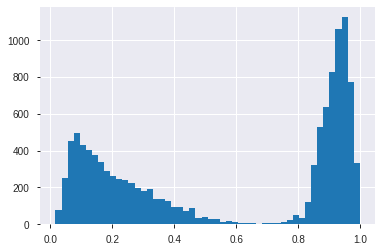

In [95]:
hist(values, bins=50)
plt.show()

In [96]:
len(values[values > 0.65]) / 12.29

479.0073230268511

In [97]:
len(values) - len(values[values > 0.65]) + len(values[values > 0.65]) / 12.29

6084.007323026851

480 пользователь из 6084, или примерно 8% - это те, которых будем включать в кампанию. Доля оттока в изначальном сете - примерно 7.5% Значит наше предположение подтверждается. И мы включим сюда пользователей, которые тоже возможно подумывают уйти.

Будем брать даже больше чем топ 25% для участия в компании, т.к. модель показывает что в верхней четверти повышается вероятность оттока. Если взять пользователей топ-1% то охват будет меньше и возможно в топ1% находятся те пользователи, которые точно решили оттечь и тратить только на них силы может быть бессмысленно. Возможно даже будет иметь сямысл отрезать топ1% и НЕ проводить компанию для тех, кто точно собрался уходить, но это тема другого исследования.

In [101]:
X_test['labels'] = y_test

In [102]:
X_test['labels'].value_counts()

 1.0    5873
-1.0    5619
Name: labels, dtype: int64

In [109]:
def undersampling(data, alpha):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    countChurn = len(dataChurn)
    countNoChurn = len(dataNoChurn)
    np.random.seed(42)
    rands = np.random.randint(0,countNoChurn, int(countChurn*alpha))
    dataNoChurn = dataNoChurn.append(dataChurn.iloc[rands,:])
    dataNoChurn = shuffle(dataNoChurn)
    return dataNoChurn

In [110]:
X2 = undersampling(X_test, 0.08137)

In [111]:
X2['labels'].value_counts()

-1.0    5619
 1.0     477
Name: labels, dtype: int64

In [112]:
y2 = X2.labels
X2.drop('labels',axis=1,inplace=True)

In [224]:
def emodel(users, income_per_user, expences_per_user, efficiency):
    total = users*(income_per_user - expences_per_user)* efficiency
    return total

Прикинем на 1000 пользователей как влияет на доход сумма удержания при эффективности кампании 85%

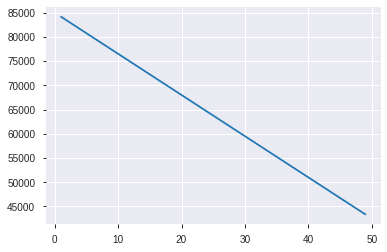

In [227]:
plot(range(1,50),[emodel(1000,100,x,0.85)for x in range(1,50)])

Логично, что с повышением расходов прибыль падает.

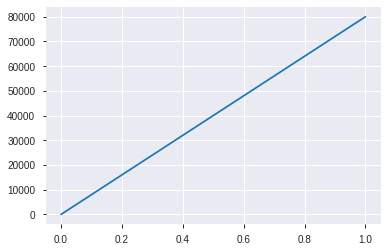

In [229]:
plot(np.linspace(0,1,100),[emodel(1000,100,20,x) for x in np.linspace(0,1,100)])

Доход растет при увеличении эффективности кампании. 

In [113]:
def model_without (revenue, top ):
    values = estimator.predict_proba(X2)[:,1]
    lst = [(value, int(y2.values[i]), i) for (i,value) in enumerate(values)]
    lst.sort(key = lambda x: -x[0])
    equety = []
    for i in top:
        cnt = int(len(lst) * i /100)
        cnt_churn = len([value for (i,value) in enumerate(lst[:cnt]) if value[1] == 1])
        income = cnt * revenue - cnt_churn * revenue
        equety.append(income)
    return equety

In [114]:
def model_with (revenue, cost, proba, top):
    values = estimator.predict_proba(X2)[:,1]
    lst = [(value, int(y2.values[i]), i) for (i,value) in enumerate(values)]
    lst.sort(key = lambda x: -x[0])
    equety = []
    for i in top:
        cnt = int(len(lst) * i /100)
        cnt_churn = len([value for (i,value) in enumerate(lst[:cnt]) if value[1] == 1])
        costs = cost * cnt
        income = cnt * revenue - ((1 - proba) * cnt_churn * revenue)
        equety.append(income - costs)
    return equety

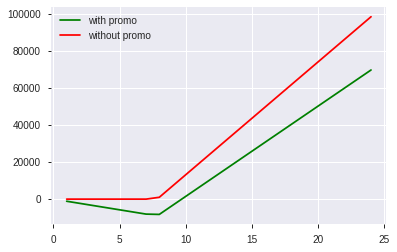

In [145]:
with_promo = model_with (revenue = 100, cost = 20, proba = 0.01, top = range(1,25))
without_promo = model_without (revenue = 100, top = range(1,25))
x = range(1, 25, 1)
plot(x, with_promo, color="g", label="with promo")
plot(x, without_promo, color="r", label="without promo")
plt.legend()
plt.show()

При затратах на удержание 20 руб, прибыль равна нулю при привлечении примерно 9% пользователей при эффективности кампании 1%

Посчитаем только абонентов склонных к оттоку

In [130]:
def model_updated (revenue, cost, proba, top):
    values = estimator.predict_proba(X2)[:,1]
    lst = [(value, int(y2.values[i]), i) for (i,value) in enumerate(values)]
    lst.sort(key = lambda x: -x[0])
    equety = []
    income = 0
    for i in top:
        cnt = int(len(lst) * i /100)
        cnt_churn = len([value for (i,value) in enumerate(lst[:cnt]) if value[1] == 1])
        costs = cost * cnt
        income += revenue*proba*cnt_churn
        equety.append(income - costs)
        income = 0
    return equety

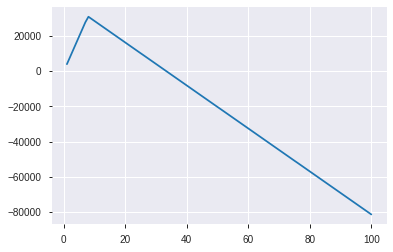

In [146]:
x = range(1, 101, 1)
plot(x, model_updated(revenue = 100, cost = 20, proba = 0.85, top = range(1,101)))

2. Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим? 

In [150]:
res = model_updated(revenue = 100, cost = 20, proba = 0.85, top = range(1,101))

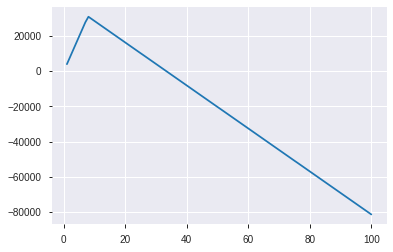

In [151]:
plot(x, res)

In [152]:
print('max revenue is %s with top of %d percents' % (max(res), res.index(max(res))))

max revenue is 30805.0 with top of 7 percents


3. Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа? 

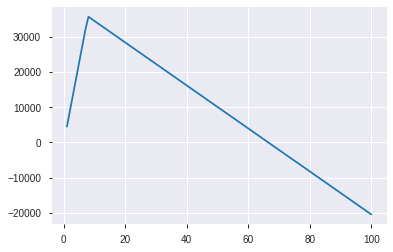

In [153]:
plot(x, model_updated(revenue = 100, cost = 10, proba = 0.85, top = range(1,101)))

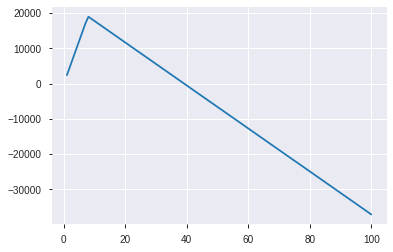

In [154]:
plot(x, model_updated(revenue = 100, cost = 10, proba = 0.5, top = range(1,101)))

Доход прямо пропорционален эффективности компании и обратно к стоимости привлечения, что более чем логично.

4. Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

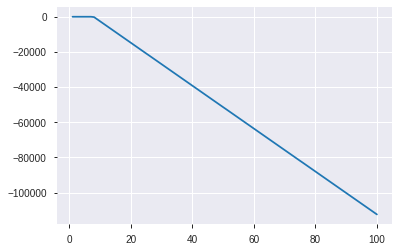

In [156]:
plot(x, model_updated(revenue = 100, cost =20, proba = 0.2, top = range(1,101)))

Конечно не всегда. при стоимости более 20 и эффективности 20% модель не имеет никакого профита совсем, только расходы при росте охвата пользователей

5. Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.

Метрика F1 что является отношением (precesion*recall)/(precesion+recall)

В задачах как эта важным является снижение ложноотрицательных ответов, то есть тех, кого мы не предсказали как уходящих, а они на самом деле ушли. Модель была обучена на специально сбалансированном сете и переучилась на минимизмцию ошибок второго рода, но при этом часто определяет лояльного абонента как собирающегося свалить. Соответственно при увеличении качества модели будет увеличиваться precision, что значит, что ошибок первого рода( отнесение лояльного пользователя к оттоку) будет меньше. Что влияет на уменьшение стоимости кампании при сопоставимой эффективности.

при 1% это будет 0.01 * 477 = 5 пользователей исключаем из кампании, при 3% - 15. Снижение затрат - 100 и 300 рублей соответственно, при стоимости удержания 20 руб/пользователь

6. Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

Я думаю, что улучшение модели необходимо проводить в степени дифференциации пользователей, не просто отток/не отток, а например, деление по лояльности и уже к соответствующим группам применять разные модели удержания, стимулирования и т.п. То есть применение такой простой модели неоправдано в современных реалиях